In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

import os
import numpy as np
import matplotlib.pyplot as plt

In [23]:
batch_size = 32
epochs = 16
IMG_HEIGHT = 244
IMG_WIDTH = 244
SHUFFLE_BUFFER_SIZE = 1000
RANDOM_SEED = 10

In [24]:
PATH = './data'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_yes_dir = os.path.join(train_dir, 'yes')  # directory with our training cat pictures
train_no_dir = os.path.join(train_dir, 'no')  # directory with our training dog pictures
validation_yes_dir = os.path.join(validation_dir, 'yes')  # directory with our validation cat pictures
validation_no_dir = os.path.join(validation_dir, 'no')  # directory with our validation dog pictures
print(train_dir)
print(validation_dir)

print(train_yes_dir)
print(train_no_dir)
print(validation_yes_dir)
print(validation_no_dir)

./data\train
./data\validation
./data\train\yes
./data\train\no
./data\validation\yes
./data\validation\no


In [35]:
num_yes_tr = len(os.listdir(train_yes_dir))
num_no_tr = len(os.listdir(train_no_dir))

num_yes_val = len(os.listdir(validation_yes_dir))
num_no_val = len(os.listdir(validation_no_dir))

total_train = num_yes_tr + num_no_tr
total_val = num_yes_val + num_no_val

print('total training yes images:', num_yes_tr)
print('total training no images:', num_no_tr)

print('total validation yes images:', num_yes_val)
print('total validation no images:', num_no_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training yes images: 130
total training no images: 79
total validation yes images: 25
total validation no images: 19
--
Total training images: 209
Total validation images: 44


In [40]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                          horizontal_flip=True,
                                            vertical_flip=True)
validation_image_generator = ImageDataGenerator(rescale=1./255,
                                               horizontal_flip=True,
                                                vertical_flip=True)

In [41]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           seed=RANDOM_SEED)

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary',
                                                              seed=RANDOM_SEED)

Found 209 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [42]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

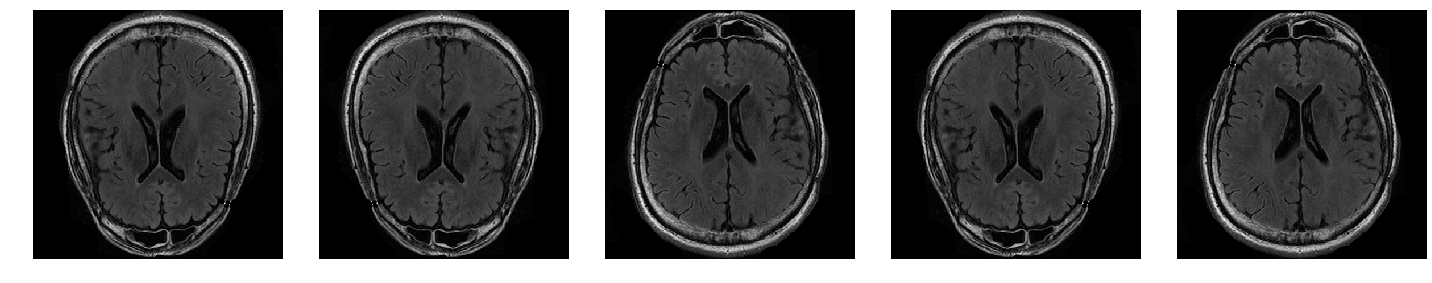

In [43]:
augmented_images = [train_data_gen[0][0][2] for i in range(5)]
plotImages(augmented_images)

In [44]:
IMG_SHAPE = (IMG_HEIGHT, IMG_HEIGHT, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [45]:
model = Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [46]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [47]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                                            mode='max', 
                                            patience=5)
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=30,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[callback],
    verbose = 1)

# print(history.history.keys())
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']



Epoch 1/30
7/7 [==============================] - 99s 14s/step - loss: 1.0525 - acc: 0.5024 - val_loss: 0.5619 - val_acc: 0.5909
Epoch 2/30
7/7 [==============================] - 96s 14s/step - loss: 0.6106 - acc: 0.6938 - val_loss: 0.3369 - val_acc: 0.8864
Epoch 3/30
7/7 [==============================] - 98s 14s/step - loss: 0.4684 - acc: 0.7608 - val_loss: 0.2810 - val_acc: 0.8636
Epoch 4/30
7/7 [==============================] - 96s 14s/step - loss: 0.4437 - acc: 0.7943 - val_loss: 0.3007 - val_acc: 0.9091
Epoch 5/30
7/7 [==============================] - 96s 14s/step - loss: 0.3777 - acc: 0.8278 - val_loss: 0.3224 - val_acc: 0.8409
Epoch 6/30
7/7 [==============================] - 96s 14s/step - loss: 0.2945 - acc: 0.8900 - val_loss: 0.2744 - val_acc: 0.9091
Epoch 7/30
7/7 [==============================] - 97s 14s/step - loss: 0.3040 - acc: 0.8852 - val_loss: 0.4162 - val_acc: 0.8409
Epoch 8/30
7/7 [==============================] - 96s 14s/step - loss: 0.3114 - acc: 0.8804 - val

NameError: name 'acc' is not defined

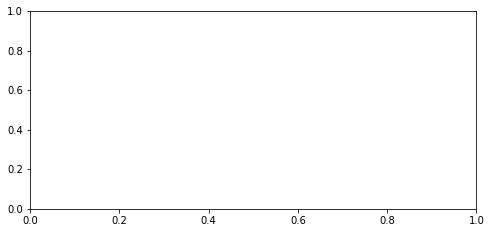

In [48]:
epochs_range = range(10) 

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()